In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nexuskan import KAN
import numpy as np
import matplotlib.pyplot as plt
from nexuskan import *

from nexuskan.utils import create_dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# $y = e^{\sin{\pi x_0} + x_1^2}$

In [3]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y = torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000],
    # 'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:],
    # 'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

## **L2 regularization** 

In [4]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.001
        l2_reg = sum(torch.norm(p, 2) for p in model.parameters())
        loss = train_loss + lamb * l2_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l2_reg:.4f}')

Epoch [10/600], Train Loss: 1.5891, Test Loss: 1.2615, reg: 42.2227
Epoch [20/600], Train Loss: 0.2025, Test Loss: 0.1437, reg: 47.7925
Epoch [30/600], Train Loss: 0.0779, Test Loss: 0.0769, reg: 50.7228
Epoch [40/600], Train Loss: 0.0362, Test Loss: 0.0311, reg: 51.7176
Epoch [50/600], Train Loss: 0.0161, Test Loss: 0.0210, reg: 51.8014
Epoch [60/600], Train Loss: 0.0089, Test Loss: 0.0109, reg: 51.7869
Epoch [70/600], Train Loss: 0.0060, Test Loss: 0.0073, reg: 51.5313
Epoch [80/600], Train Loss: 0.0041, Test Loss: 0.0047, reg: 51.3386
Epoch [90/600], Train Loss: 0.0030, Test Loss: 0.0037, reg: 51.0935
Epoch [100/600], Train Loss: 0.0023, Test Loss: 0.0026, reg: 50.9037
Epoch [110/600], Train Loss: 0.0018, Test Loss: 0.0020, reg: 50.7296
Epoch [120/600], Train Loss: 0.0015, Test Loss: 0.0016, reg: 50.5546
Epoch [130/600], Train Loss: 0.0013, Test Loss: 0.0014, reg: 50.3726
Epoch [140/600], Train Loss: 0.0011, Test Loss: 0.0012, reg: 50.1931
Epoch [150/600], Train Loss: 0.0010, Test L

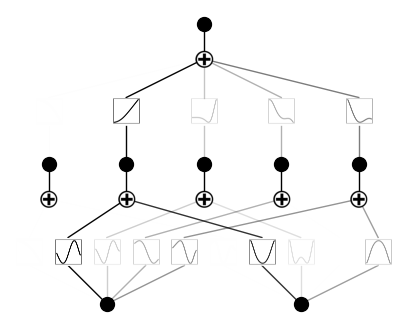

In [6]:
model.plot()

saving model version 0.1


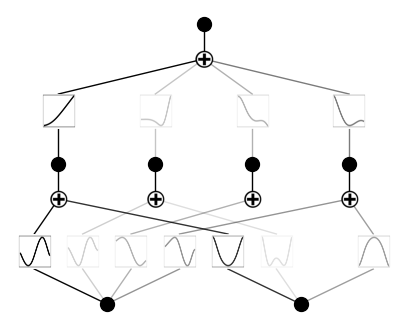

In [7]:
model = model.prune()
model.plot()

## **L1 regularization**

In [55]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.01
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l2_reg:.4f}')

Epoch [10/600], Train Loss: 1.0345, Test Loss: 0.9166, reg: 43.9159
Epoch [20/600], Train Loss: 0.6114, Test Loss: 0.5680, reg: 43.9159
Epoch [30/600], Train Loss: 0.1325, Test Loss: 0.1612, reg: 43.9159
Epoch [40/600], Train Loss: 0.0458, Test Loss: 0.0410, reg: 43.9159
Epoch [50/600], Train Loss: 0.0257, Test Loss: 0.0338, reg: 43.9159
Epoch [60/600], Train Loss: 0.0279, Test Loss: 0.0319, reg: 43.9159
Epoch [70/600], Train Loss: 0.0246, Test Loss: 0.0272, reg: 43.9159
Epoch [80/600], Train Loss: 0.0223, Test Loss: 0.0239, reg: 43.9159
Epoch [90/600], Train Loss: 0.0805, Test Loss: 0.0298, reg: 43.9159
Epoch [100/600], Train Loss: 0.0274, Test Loss: 0.0334, reg: 43.9159
Epoch [110/600], Train Loss: 0.0188, Test Loss: 0.0286, reg: 43.9159
Epoch [120/600], Train Loss: 0.0219, Test Loss: 0.0187, reg: 43.9159
Epoch [130/600], Train Loss: 0.0192, Test Loss: 0.0203, reg: 43.9159
Epoch [140/600], Train Loss: 0.0187, Test Loss: 0.0193, reg: 43.9159
Epoch [150/600], Train Loss: 0.0277, Test L

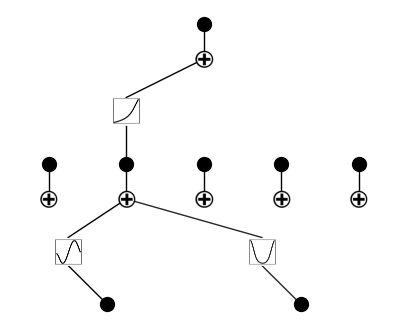

In [57]:
model.plot()

saving model version 0.1


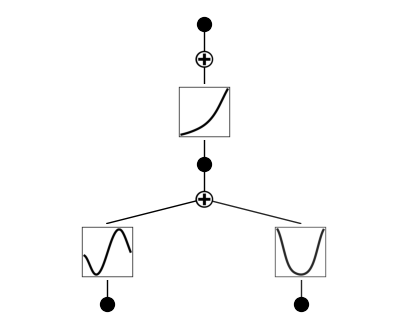

In [58]:
model = model.prune()
model.plot()

## **Lp regularization (p = 0.5)** 

In [67]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.0001
        lp_reg = sum(torch.norm(p, 0.5) for p in model.parameters())
        loss = train_loss + lamb * lp_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l2_reg:.4f}')

Epoch [10/600], Train Loss: 1.0643, Test Loss: 0.8851, reg: 43.9159
Epoch [20/600], Train Loss: 0.3423, Test Loss: 0.3189, reg: 43.9159
Epoch [30/600], Train Loss: 0.0868, Test Loss: 0.0800, reg: 43.9159
Epoch [40/600], Train Loss: 0.0378, Test Loss: 0.0389, reg: 43.9159
Epoch [50/600], Train Loss: 0.0270, Test Loss: 0.0270, reg: 43.9159
Epoch [60/600], Train Loss: 0.0185, Test Loss: 0.0209, reg: 43.9159
Epoch [70/600], Train Loss: 0.0138, Test Loss: 0.0165, reg: 43.9159
Epoch [80/600], Train Loss: 0.0139, Test Loss: 0.0159, reg: 43.9159
Epoch [90/600], Train Loss: 0.0400, Test Loss: 0.0332, reg: 43.9159
Epoch [100/600], Train Loss: 0.0189, Test Loss: 0.0231, reg: 43.9159
Epoch [110/600], Train Loss: 0.0103, Test Loss: 0.0129, reg: 43.9159
Epoch [120/600], Train Loss: 0.0132, Test Loss: 0.0164, reg: 43.9159
Epoch [130/600], Train Loss: 0.0285, Test Loss: 0.0186, reg: 43.9159
Epoch [140/600], Train Loss: 0.0185, Test Loss: 0.0163, reg: 43.9159
Epoch [150/600], Train Loss: 0.0142, Test L

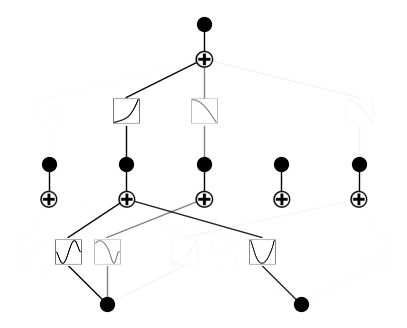

In [69]:
model.plot()

saving model version 0.1


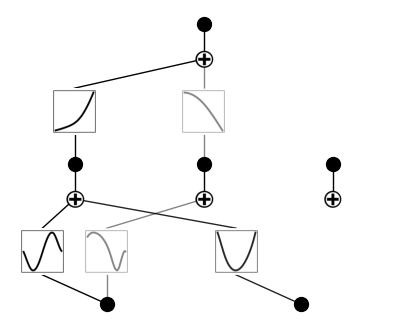

In [70]:
model = model.prune()
model.plot()

# **L1 regularization** $y = \sin{2 \pi x_0} + \sin{\pi x_1} + \sin{\pi x_2}$

In [12]:
end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 3) + start_range
y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(torch.pi * x[:, 1]) + torch.sin(torch.pi * x[:, 2])
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    # 'train_label': y_class[:1000].unsqueeze(dim=1),
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    # 'test_label': y_class[-200:].unsqueeze(dim=1),
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 3]), torch.Size([1000, 1]))

In [13]:
model = KAN(width=[3, 5, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # lamb = 0.0
        lamb = 0.01
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/600], Train Loss: 0.2162, Test Loss: 0.2164, reg: 193.8226
Epoch [20/600], Train Loss: 0.0559, Test Loss: 0.0535, reg: 191.7373
Epoch [30/600], Train Loss: 0.0334, Test Loss: 0.0331, reg: 181.3410
Epoch [40/600], Train Loss: 0.0216, Test Loss: 0.0213, reg: 176.9021
Epoch [50/600], Train Loss: 0.0200, Test Loss: 0.0216, reg: 172.6870
Epoch [60/600], Train Loss: 0.0184, Test Loss: 0.0223, reg: 169.6955
Epoch [70/600], Train Loss: 0.0221, Test Loss: 0.0180, reg: 168.3388
Epoch [80/600], Train Loss: 0.0173, Test Loss: 0.0170, reg: 167.5451
Epoch [90/600], Train Loss: 0.0181, Test Loss: 0.0178, reg: 167.1895
Epoch [100/600], Train Loss: 0.0296, Test Loss: 0.0335, reg: 166.4323
Epoch [110/600], Train Loss: 0.0216, Test Loss: 0.0220, reg: 166.4943
Epoch [120/600], Train Loss: 0.0183, Test Loss: 0.0201, reg: 165.9983
Epoch [130/600], Train Loss: 0.0192, Test Loss: 0.0191, reg: 165.7624
Epoch [140/600], Train Loss: 0.0174, Test Loss: 0.0168, reg: 165.3473
Epoch [150/600], Train Loss: 

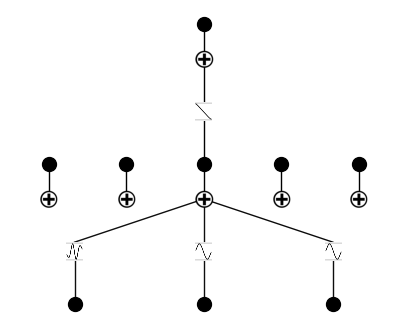

In [15]:
model.plot()

saving model version 0.1


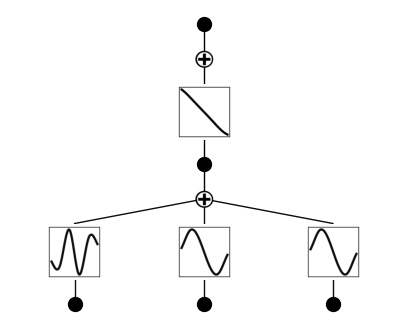

In [16]:
model = model.prune()
model.plot()

fixing (0,0,0) with sin, r2=0.9747248888015747, c=2
fixing (0,1,0) with sin, r2=0.9994927048683167, c=2
fixing (0,2,0) with sin, r2=0.9994242191314697, c=2
fixing (1,0,0) with x, r2=0.9995030164718628, c=1
saving model version 0.2


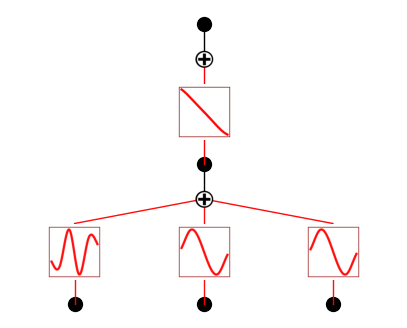

In [17]:
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
model.auto_symbolic(lib=lib)
model.plot()

In [18]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.9711*sin(6.3195*x_1 - 0.0118) + 0.9869*sin(3.1359*x_2 - 0.0062) + 0.9888*sin(3.1373*x_3 - 0.001) - 0.0074